In [5]:
import ast
import math
import pickle
from collections import Counter, deque
import warnings
import numpy as np
import pandas as pd
import torch
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.metrics import (accuracy_score, average_precision_score, f1_score,
                             precision_score, recall_score, roc_auc_score)
from sklearn.preprocessing import MultiLabelBinarizer
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import networkx as nx
import obonet
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import StandardScaler
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold, MultilabelStratifiedShuffleSplit
import random
import json

import os, sys

from utils_corrected import process_GO_data

# Keep  custom implementations of these functions since they have different signatures/implementations:
# - evaluate_annotations 
# - threshold_performance_metrics 
# - _calculate_metrics_at_threshold 
# - process_threshold

data_train_embeddings_path = '/shared/projects/deepmar/data/bacteria_sequences/function_only/processed_data_90_30/function_train.npy'
data_train_tsv_path = '/shared/projects/deepmar/data/bacteria_sequences/function_only/processed_data_90_30/function_train.tsv'
data_val_embeddings_path = '/shared/projects/deepmar/data/bacteria_sequences/function_only/processed_data_90_30/function_val.npy'
data_val_tsv_path = '/shared/projects/deepmar/data/bacteria_sequences/function_only/processed_data_90_30/function_val.tsv'

data_train_embeddings = np.load(data_train_embeddings_path)
data_val_embeddings = np.load(data_val_embeddings_path)
print(data_train_embeddings.shape, data_val_embeddings.shape)

data_train_tsv, data_train_embeddings, data_train_GO_list, data_train_GO_annotated = process_GO_data(data_train_tsv_path, data_train_embeddings)
data_val_tsv, data_val_embeddings, data_val_GO_list, data_val_GO_annotated = process_GO_data(data_val_tsv_path, data_val_embeddings)

print(data_train_tsv.shape, data_val_tsv.shape)

data_mlb = MultiLabelBinarizer()

data_train_labels = data_mlb.fit_transform(data_train_GO_list)
data_val_labels = data_mlb.transform(data_val_GO_list)
unique_data_train_terms = data_mlb.classes_


with open('./data_mlb.pkl', 'wb') as f:
    pickle.dump(data_mlb, f)


print(data_train_labels.shape, data_val_labels.shape)


(129887, 512) (10804, 512)
(129887, 14) (10804, 15)
(129887, 1098) (10804, 1098)


In [6]:
def evaluate_annotations(ic_dict, real_annots, pred_annots):
    """
    Evaluates precision, recall, F1-score, remaining uncertainty (ru), and misinformation (mi)
    for a given set of real and predicted annotations using the IC dictionary.

    ic_dict: Dictionary mapping GO terms to IC values
    real_annots: List of true annotations for each protein
    pred_annots: List of predicted annotations for each protein
    """
    total = 0
    p_sum = 0.0
    r_sum = 0.0
    p_total = 0
    ru = 0.0
    mi = 0.0
    fps = []
    fns = []
    tp_global, fp_global, fn_global = 0, 0, 0  
    
    for i in range(len(real_annots)):
        if len(real_annots[i]) == 0:
            continue
        
        tp = set(real_annots[i]).intersection(set(pred_annots[i]))
        fp = pred_annots[i] - tp
        fn = real_annots[i] - tp
        
        tp_global += len(tp)
        fp_global += len(fp)
        fn_global += len(fn)
        
        for go_id in fp:
            if go_id in ic_dict:
                mi += ic_dict[go_id]
        
        for go_id in fn:
            if go_id in ic_dict:
                ru += ic_dict[go_id]
        
        fps.append(fp)
        fns.append(fn)
        total += 1
        
        recall = len(tp) / (len(tp) + len(fn)) if (len(tp) + len(fn)) > 0 else 0
        precision = len(tp) / (len(tp) + len(fp)) if (len(tp) + len(fp)) > 0 else 0
        
        r_sum += recall
        if len(pred_annots[i]) > 0:
            p_total += 1
            p_sum += precision
    
    r = r_sum / total if total > 0 else 0
    p = p_sum / p_total if p_total > 0 else 0
    
    p_micro = tp_global / (tp_global + fp_global) if (tp_global + fp_global) > 0 else 0
    r_micro = tp_global / (tp_global + fn_global) if (tp_global + fn_global) > 0 else 0
    
    f = 2 * p * r / (p + r) if (p + r) > 0 else 0
    f_micro = 2 * p_micro * r_micro / (p_micro + r_micro) if (p_micro + r_micro) > 0 else 0
    
    ru /= total
    mi /= total
    
    s = math.sqrt(ru * ru + mi * mi)
    
    return f, p, r, s, ru, mi, f_micro, p_micro, r_micro, tp_global, fp_global, fn_global






def process_threshold(threshold, ic_dict, y_true, y_pred_probs, mlb):
    """
    Helper function to calculate metrics at a specific threshold.
    This is called within parallelization support.

    threshold: The current threshold to evaluate
    ic_dict: Dictionary mapping GO terms to IC values
    y_true: Ground truth binary annotations (2D array)
    y_pred_probs: Prediction probabilities (2D array)
    mlb: MultiLabelBinarizer object

    """
    return _calculate_metrics_at_threshold(ic_dict, y_true, y_pred_probs, threshold, mlb)


def threshold_performance_metrics(ic_dict, y_true, y_pred_probs, threshold_range=None, set_threshold=None, n_jobs=1, mlb=None):
    """
    Calculates S-min and F-max over a range of thresholds or at a set threshold.

    ic_dict: Dictionary mapping GO terms to IC values
    y_true: Ground truth binary annotations (2D array)
    y_pred_probs: Prediction probabilities (2D array)
    threshold_range: Range of thresholds to evaluate (if None, only calculates metrics at set_threshold)
    set_threshold: Specific threshold to calculate metrics (if provided)
    mlb: MultiLabelBinarizer object for converting predictions and targets back to sets of terms
    n_jobs: Number of parallel jobs
    
    """
    
    if threshold_range is None and set_threshold is None:
        raise ValueError("Either threshold_range or set_threshold must be provided.")
    
    if set_threshold is not None:
        # Calculate metrics for the given set threshold only
        return _calculate_metrics_at_threshold(ic_dict, y_true, y_pred_probs, set_threshold, mlb)

    smin = float('inf')
    fmax = 0
    best_threshold_s = None
    best_threshold_f = None
    s_at_fmax = None
    results = []

    # Parallelization support
    if n_jobs > 1:
        with Pool(n_jobs) as pool:
            results = list(tqdm(pool.imap(lambda t: process_threshold(t, ic_dict, y_true, y_pred_probs, mlb), threshold_range), total=len(threshold_range)))
    else:
        results = [process_threshold(threshold, ic_dict, y_true, y_pred_probs, mlb) for threshold in tqdm(threshold_range, desc='Calculating Smin & Fmax')]

    results_df = pd.DataFrame(results)

    for row in results:
        if row['s'] < smin:
            smin = row['s']
            best_threshold_s = row['n']
        if row['f'] > fmax:
            fmax = row['f']
            best_threshold_f = row['n']
            s_at_fmax = row['s']  

    print(f"F-max @ Best Threshold ({best_threshold_f}): {fmax}")
    print(f"S-min @ Best Threshold ({best_threshold_s}): {smin}")
    print(f"S-min @ F-max Threshold ({best_threshold_f}): {s_at_fmax}")

    return smin, fmax, best_threshold_s, best_threshold_f, s_at_fmax, results_df



def _calculate_metrics_at_threshold(ic_dict, y_true, y_pred_probs, threshold, mlb):
    """
    Helper function to calculate metrics at a specific threshold.

    ic_dict: Dictionary mapping GO terms to IC values
    y_true: Ground truth binary annotations (2D array)
    y_pred_probs: Prediction probabilities (2D array)
    threshold: Specific threshold to calculate metrics
    mlb: MultiLabelBinarizer object
    """
    y_pred_binary = (y_pred_probs > threshold).astype(int)

    pred_annotations = mlb.inverse_transform(y_pred_binary)
    pred_annots_inverse = [set(item) for item in pred_annotations]
    
    test_targets_inverse = mlb.inverse_transform(y_true)
    real_annots_inverse = [set(item) for item in test_targets_inverse]

    f, p, r, s, ru, mi, f_micro, p_micro, r_micro, tp_global, fp_global, fn_global = evaluate_annotations(ic_dict, real_annots_inverse, pred_annots_inverse)
    
    cov = len([1 for preds in pred_annotations if len(preds) > 0]) / len(y_true)
    
    return {
        'n': threshold, 
        'tp': tp_global, 
        'fp': fp_global, 
        'fn': fn_global, 
        'pr': p, 
        'rc': r, 
        'cov': cov, 
        'mi': mi, 
        'ru': ru, 
        'f': f, 
        's': s, 
        'pr_micro': p_micro, 
        'rc_micro': r_micro, 
        'f_micro': f_micro, 
        'cov_max': cov
    }


In [7]:
ia_df = pd.read_csv(r'../IA_all.tsv', sep='\t', header=None)
ia_df.columns = ['GO', 'IA']

ic_dict = dict(zip(ia_df['GO'], ia_df['IA']))

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

data_train_dataset = TensorDataset(torch.tensor(data_train_embeddings, dtype=torch.float).to(device),
                                       torch.tensor(data_train_labels, dtype=torch.float).to(device))
data_val_dataset = TensorDataset(torch.tensor(data_val_embeddings, dtype=torch.float).to(device),
                                     torch.tensor(data_val_labels, dtype=torch.float).to(device))

data_train_loader = DataLoader(data_train_dataset, batch_size=1024, shuffle=True)
data_val_loader = DataLoader(data_val_dataset, batch_size=1024, shuffle=False)

class FFNN(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, dropout_rate=0.4):
        super(FFNN, self).__init__()
        layers = []
        dims = [input_dim] + hidden_dims
        for i in range(len(dims) - 1):
            layers.append(nn.Linear(dims[i], dims[i + 1]))
            layers.append(nn.LeakyReLU())
        
        if dims[-1] != 2:  # Apply dropout only before the last output layer, if the last hidden layer is not 2D
            layers.append(nn.Dropout(dropout_rate))
        
        layers.append(nn.Linear(dims[-1], output_dim))  # Final layer (output layer)
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

def save_to_tsv(filename, data, mlb):
    with open(filename, 'w') as f:
        for i, row in enumerate(data):
            for j, val in enumerate(row):
                if val >= 0.01:  # Using threshold 0.5 for binary classification
                    term = mlb.classes_[j]
                    f.write(f"T_{i + 1}\t{term}\t{val:.4f}\n")

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, model_save_path):
    model = model.to(device)
    train_losses = []
    val_losses = []

    print("Starting training...")
    
    for epoch in tqdm(range(num_epochs), desc=f"Epoch progress"):
        model.train()
        train_loss = 0.0
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validate after each epoch
        val_loss = evaluate_model(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        
        torch.save(model.state_dict(), model_save_path)

        #print(f'Epoch [{epoch + 1}/{num_epochs}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f}')

    print("Training completed.")
    return train_losses, val_losses

def evaluate_model(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    return avg_val_loss

def run_prediction_tsv(model, val_loader, mlb, num_epochs, lr, arch):
    model.eval()
    all_preds = []
    all_targets = []

    print("Generating prediction TSVs...")
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch = x_batch.to(device)
            outputs = model(x_batch)
            preds = torch.sigmoid(outputs).cpu().numpy()  # Apply sigmoid for probability outputs
            all_preds.append(preds)
            all_targets.append(y_batch.cpu().numpy())

    # Stack predictions and targets into numpy arrays
    predictions = np.vstack(all_preds)

    pred_file = f"predictions_lr{lr}_arch{arch}_epochs{num_epochs}.tsv"
    save_to_tsv(pred_file, predictions, mlb)
    print(f"Saved: {pred_file}")

def save_ground_truth(val_loader, mlb):
    print("Generating ground truth TSV once...")
    all_targets = []
    with torch.no_grad():
        for _, y_batch in val_loader:
            all_targets.append(y_batch.cpu().numpy())
    
    targets = np.vstack(all_targets)
    
    truth_file = "ground_truth.tsv"
    save_to_tsv(truth_file, targets, mlb)
    print(f"Ground truth saved: {truth_file}")

architectures = [
    [256],  # 512 → 256
    [256, 128],  # 512 → 256 → 128
    [256, 128, 64],  # 512 → 256 → 128 → 64
    [256, 128, 62, 32],  # 512 → 256 → 128 → 62 → 32
    # [256, 128, 62, 32, 16],
    # [256, 128, 62, 32, 16, 8],
    # [256, 128, 62, 32, 16, 8, 4],
    # [256, 128, 62, 32, 16, 8, 4, 2]
]

learning_rates = [0.01, 0.001, 0.0001, 0.00001]
epoch_counts = [10, 15, 20, 30, 40]



Using device: cuda



Training with LR: 0.01, Arch: [256], Epochs: 10
Starting training...


Epoch progress: 100%|██████████| 10/10 [00:08<00:00,  1.22it/s]


Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:02<00:00,  3.82it/s]


F-max @ Best Threshold (0.1): 0.7985960378088984
S-min @ Best Threshold (0.2): 4.526839007071179
S-min @ F-max Threshold (0.1): 4.742863863763243
Saved metrics to: metrics_lr0.01_arch[256]_epochs10.csv
Completed training and evaluation for config: LR=0.01, ARCH=[256], EPOCHS=10

Training with LR: 0.01, Arch: [256], Epochs: 15
Starting training...


Epoch progress: 100%|██████████| 15/15 [00:11<00:00,  1.30it/s]


Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:02<00:00,  3.89it/s]


F-max @ Best Threshold (0.1): 0.8112990980449566
S-min @ Best Threshold (0.1): 4.45292020872906
S-min @ F-max Threshold (0.1): 4.45292020872906
Saved metrics to: metrics_lr0.01_arch[256]_epochs15.csv
Completed training and evaluation for config: LR=0.01, ARCH=[256], EPOCHS=15

Training with LR: 0.01, Arch: [256], Epochs: 20
Starting training...


Epoch progress: 100%|██████████| 20/20 [00:15<00:00,  1.30it/s]


Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:02<00:00,  3.84it/s]


F-max @ Best Threshold (0.1): 0.8102402697179021
S-min @ Best Threshold (0.2): 4.4349634139815794
S-min @ F-max Threshold (0.1): 4.500717649049308
Saved metrics to: metrics_lr0.01_arch[256]_epochs20.csv
Completed training and evaluation for config: LR=0.01, ARCH=[256], EPOCHS=20

Training with LR: 0.01, Arch: [256], Epochs: 30
Starting training...


Epoch progress: 100%|██████████| 30/30 [00:23<00:00,  1.28it/s]


Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:02<00:00,  3.84it/s]


F-max @ Best Threshold (0.2): 0.8094728932819649
S-min @ Best Threshold (0.2): 4.436881482865344
S-min @ F-max Threshold (0.2): 4.436881482865344
Saved metrics to: metrics_lr0.01_arch[256]_epochs30.csv
Completed training and evaluation for config: LR=0.01, ARCH=[256], EPOCHS=30

Training with LR: 0.01, Arch: [256], Epochs: 40
Starting training...


Epoch progress: 100%|██████████| 40/40 [00:30<00:00,  1.29it/s]


Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:02<00:00,  3.79it/s]


F-max @ Best Threshold (0.1): 0.7999095184592333
S-min @ Best Threshold (0.1): 4.626219691543628
S-min @ F-max Threshold (0.1): 4.626219691543628
Saved metrics to: metrics_lr0.01_arch[256]_epochs40.csv
Completed training and evaluation for config: LR=0.01, ARCH=[256], EPOCHS=40

Training with LR: 0.01, Arch: [256, 128], Epochs: 10
Starting training...


Epoch progress: 100%|██████████| 10/10 [00:07<00:00,  1.27it/s]


Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:02<00:00,  3.85it/s]


F-max @ Best Threshold (0.30000000000000004): 0.7874633699209899
S-min @ Best Threshold (0.30000000000000004): 4.999310612340294
S-min @ F-max Threshold (0.30000000000000004): 4.999310612340294
Saved metrics to: metrics_lr0.01_arch[256, 128]_epochs10.csv
Completed training and evaluation for config: LR=0.01, ARCH=[256, 128], EPOCHS=10

Training with LR: 0.01, Arch: [256, 128], Epochs: 15
Starting training...


Epoch progress: 100%|██████████| 15/15 [00:11<00:00,  1.29it/s]


Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:02<00:00,  3.84it/s]


F-max @ Best Threshold (0.30000000000000004): 0.7922087516270234
S-min @ Best Threshold (0.30000000000000004): 4.9727093734554195
S-min @ F-max Threshold (0.30000000000000004): 4.9727093734554195
Saved metrics to: metrics_lr0.01_arch[256, 128]_epochs15.csv
Completed training and evaluation for config: LR=0.01, ARCH=[256, 128], EPOCHS=15

Training with LR: 0.01, Arch: [256, 128], Epochs: 20
Starting training...


Epoch progress: 100%|██████████| 20/20 [00:15<00:00,  1.30it/s]


Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:02<00:00,  3.84it/s]


F-max @ Best Threshold (0.2): 0.8072432710694889
S-min @ Best Threshold (0.30000000000000004): 4.436510449492057
S-min @ F-max Threshold (0.2): 4.439628726908478
Saved metrics to: metrics_lr0.01_arch[256, 128]_epochs20.csv
Completed training and evaluation for config: LR=0.01, ARCH=[256, 128], EPOCHS=20

Training with LR: 0.01, Arch: [256, 128], Epochs: 30
Starting training...


Epoch progress: 100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:02<00:00,  3.79it/s]


F-max @ Best Threshold (0.30000000000000004): 0.7989038720605698
S-min @ Best Threshold (0.30000000000000004): 4.889108794255198
S-min @ F-max Threshold (0.30000000000000004): 4.889108794255198
Saved metrics to: metrics_lr0.01_arch[256, 128]_epochs30.csv
Completed training and evaluation for config: LR=0.01, ARCH=[256, 128], EPOCHS=30

Training with LR: 0.01, Arch: [256, 128], Epochs: 40
Starting training...


Epoch progress: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:02<00:00,  3.83it/s]


F-max @ Best Threshold (0.4): 0.8074927558093468
S-min @ Best Threshold (0.4): 4.577597867040848
S-min @ F-max Threshold (0.4): 4.577597867040848
Saved metrics to: metrics_lr0.01_arch[256, 128]_epochs40.csv
Completed training and evaluation for config: LR=0.01, ARCH=[256, 128], EPOCHS=40

Training with LR: 0.01, Arch: [256, 128, 64], Epochs: 10
Starting training...


Epoch progress: 100%|██████████| 10/10 [00:07<00:00,  1.27it/s]


Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:02<00:00,  3.83it/s]


F-max @ Best Threshold (0.30000000000000004): 0.7656477481148701
S-min @ Best Threshold (0.30000000000000004): 5.59179012965388
S-min @ F-max Threshold (0.30000000000000004): 5.59179012965388
Saved metrics to: metrics_lr0.01_arch[256, 128, 64]_epochs10.csv
Completed training and evaluation for config: LR=0.01, ARCH=[256, 128, 64], EPOCHS=10

Training with LR: 0.01, Arch: [256, 128, 64], Epochs: 15
Starting training...


Epoch progress: 100%|██████████| 15/15 [00:11<00:00,  1.27it/s]


Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:02<00:00,  3.85it/s]


F-max @ Best Threshold (0.4): 0.7508988713818241
S-min @ Best Threshold (0.30000000000000004): 6.075896087414037
S-min @ F-max Threshold (0.4): 6.205559281431466
Saved metrics to: metrics_lr0.01_arch[256, 128, 64]_epochs15.csv
Completed training and evaluation for config: LR=0.01, ARCH=[256, 128, 64], EPOCHS=15

Training with LR: 0.01, Arch: [256, 128, 64], Epochs: 20
Starting training...


Epoch progress: 100%|██████████| 20/20 [00:15<00:00,  1.28it/s]


Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:02<00:00,  3.52it/s]


F-max @ Best Threshold (0.30000000000000004): 0.7822028943579359
S-min @ Best Threshold (0.30000000000000004): 5.1949935698884975
S-min @ F-max Threshold (0.30000000000000004): 5.1949935698884975
Saved metrics to: metrics_lr0.01_arch[256, 128, 64]_epochs20.csv
Completed training and evaluation for config: LR=0.01, ARCH=[256, 128, 64], EPOCHS=20

Training with LR: 0.01, Arch: [256, 128, 64], Epochs: 30
Starting training...


Epoch progress: 100%|██████████| 30/30 [00:23<00:00,  1.29it/s]


Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:02<00:00,  3.79it/s]


F-max @ Best Threshold (0.30000000000000004): 0.8005865288759028
S-min @ Best Threshold (0.30000000000000004): 4.71404493434128
S-min @ F-max Threshold (0.30000000000000004): 4.71404493434128
Saved metrics to: metrics_lr0.01_arch[256, 128, 64]_epochs30.csv
Completed training and evaluation for config: LR=0.01, ARCH=[256, 128, 64], EPOCHS=30

Training with LR: 0.01, Arch: [256, 128, 64], Epochs: 40
Starting training...


Epoch progress: 100%|██████████| 40/40 [00:31<00:00,  1.28it/s]


Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:02<00:00,  3.87it/s]


F-max @ Best Threshold (0.30000000000000004): 0.7864022486349102
S-min @ Best Threshold (0.30000000000000004): 5.177110656372834
S-min @ F-max Threshold (0.30000000000000004): 5.177110656372834
Saved metrics to: metrics_lr0.01_arch[256, 128, 64]_epochs40.csv
Completed training and evaluation for config: LR=0.01, ARCH=[256, 128, 64], EPOCHS=40

Training with LR: 0.01, Arch: [256, 128, 62, 32], Epochs: 10
Starting training...


Epoch progress: 100%|██████████| 10/10 [00:07<00:00,  1.26it/s]


Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:02<00:00,  3.86it/s]


F-max @ Best Threshold (0.30000000000000004): 0.7292694603465385
S-min @ Best Threshold (0.2): 6.518582363414089
S-min @ F-max Threshold (0.30000000000000004): 6.643283340465997
Saved metrics to: metrics_lr0.01_arch[256, 128, 62, 32]_epochs10.csv
Completed training and evaluation for config: LR=0.01, ARCH=[256, 128, 62, 32], EPOCHS=10

Training with LR: 0.01, Arch: [256, 128, 62, 32], Epochs: 15
Starting training...


Epoch progress: 100%|██████████| 15/15 [00:11<00:00,  1.26it/s]


Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:02<00:00,  3.47it/s]


F-max @ Best Threshold (0.30000000000000004): 0.725223817261659
S-min @ Best Threshold (0.2): 6.832904221455907
S-min @ F-max Threshold (0.30000000000000004): 6.91656512863775
Saved metrics to: metrics_lr0.01_arch[256, 128, 62, 32]_epochs15.csv
Completed training and evaluation for config: LR=0.01, ARCH=[256, 128, 62, 32], EPOCHS=15

Training with LR: 0.01, Arch: [256, 128, 62, 32], Epochs: 20
Starting training...


Epoch progress: 100%|██████████| 20/20 [00:15<00:00,  1.26it/s]


Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:02<00:00,  3.83it/s]


F-max @ Best Threshold (0.30000000000000004): 0.746667696083625
S-min @ Best Threshold (0.2): 6.406960908949755
S-min @ F-max Threshold (0.30000000000000004): 6.721762502357643
Saved metrics to: metrics_lr0.01_arch[256, 128, 62, 32]_epochs20.csv
Completed training and evaluation for config: LR=0.01, ARCH=[256, 128, 62, 32], EPOCHS=20

Training with LR: 0.01, Arch: [256, 128, 62, 32], Epochs: 30
Starting training...


Epoch progress: 100%|██████████| 30/30 [00:24<00:00,  1.25it/s]


Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:02<00:00,  3.87it/s]


F-max @ Best Threshold (0.2): 0.7564331311372282
S-min @ Best Threshold (0.2): 5.906804747075277
S-min @ F-max Threshold (0.2): 5.906804747075277
Saved metrics to: metrics_lr0.01_arch[256, 128, 62, 32]_epochs30.csv
Completed training and evaluation for config: LR=0.01, ARCH=[256, 128, 62, 32], EPOCHS=30

Training with LR: 0.01, Arch: [256, 128, 62, 32], Epochs: 40
Starting training...


Epoch progress: 100%|██████████| 40/40 [00:31<00:00,  1.26it/s]


Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:02<00:00,  3.52it/s]


F-max @ Best Threshold (0.30000000000000004): 0.7398372515727294
S-min @ Best Threshold (0.2): 6.44372485435371
S-min @ F-max Threshold (0.30000000000000004): 6.5000278682369235
Saved metrics to: metrics_lr0.01_arch[256, 128, 62, 32]_epochs40.csv
Completed training and evaluation for config: LR=0.01, ARCH=[256, 128, 62, 32], EPOCHS=40

Training with LR: 0.001, Arch: [256], Epochs: 10
Starting training...


Epoch progress: 100%|██████████| 10/10 [00:07<00:00,  1.28it/s]


Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:02<00:00,  3.85it/s]


F-max @ Best Threshold (0.2): 0.7471481477364986
S-min @ Best Threshold (0.2): 5.636339498934189
S-min @ F-max Threshold (0.2): 5.636339498934189
Saved metrics to: metrics_lr0.001_arch[256]_epochs10.csv
Completed training and evaluation for config: LR=0.001, ARCH=[256], EPOCHS=10

Training with LR: 0.001, Arch: [256], Epochs: 15
Starting training...


Epoch progress: 100%|██████████| 15/15 [00:11<00:00,  1.30it/s]


Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:02<00:00,  3.79it/s]


F-max @ Best Threshold (0.2): 0.7690349751058705
S-min @ Best Threshold (0.2): 5.0830210161258975
S-min @ F-max Threshold (0.2): 5.0830210161258975
Saved metrics to: metrics_lr0.001_arch[256]_epochs15.csv
Completed training and evaluation for config: LR=0.001, ARCH=[256], EPOCHS=15

Training with LR: 0.001, Arch: [256], Epochs: 20
Starting training...


Epoch progress: 100%|██████████| 20/20 [00:15<00:00,  1.28it/s]


Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:02<00:00,  3.79it/s]


F-max @ Best Threshold (0.2): 0.7833818739122894
S-min @ Best Threshold (0.2): 4.796642698379304
S-min @ F-max Threshold (0.2): 4.796642698379304
Saved metrics to: metrics_lr0.001_arch[256]_epochs20.csv
Completed training and evaluation for config: LR=0.001, ARCH=[256], EPOCHS=20

Training with LR: 0.001, Arch: [256], Epochs: 30
Starting training...


Epoch progress: 100%|██████████| 30/30 [00:23<00:00,  1.30it/s]


Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:02<00:00,  3.82it/s]


F-max @ Best Threshold (0.2): 0.8060739693134527
S-min @ Best Threshold (0.2): 4.380198588139725
S-min @ F-max Threshold (0.2): 4.380198588139725
Saved metrics to: metrics_lr0.001_arch[256]_epochs30.csv
Completed training and evaluation for config: LR=0.001, ARCH=[256], EPOCHS=30

Training with LR: 0.001, Arch: [256], Epochs: 40
Starting training...


Epoch progress: 100%|██████████| 40/40 [00:31<00:00,  1.28it/s]


Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:02<00:00,  3.86it/s]


F-max @ Best Threshold (0.2): 0.8114858067384251
S-min @ Best Threshold (0.2): 4.186025828841599
S-min @ F-max Threshold (0.2): 4.186025828841599
Saved metrics to: metrics_lr0.001_arch[256]_epochs40.csv
Completed training and evaluation for config: LR=0.001, ARCH=[256], EPOCHS=40

Training with LR: 0.001, Arch: [256, 128], Epochs: 10
Starting training...


Epoch progress: 100%|██████████| 10/10 [00:07<00:00,  1.31it/s]


Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:02<00:00,  3.83it/s]


F-max @ Best Threshold (0.30000000000000004): 0.7559387120016247
S-min @ Best Threshold (0.2): 5.569349187117333
S-min @ F-max Threshold (0.30000000000000004): 5.717624957969613
Saved metrics to: metrics_lr0.001_arch[256, 128]_epochs10.csv
Completed training and evaluation for config: LR=0.001, ARCH=[256, 128], EPOCHS=10

Training with LR: 0.001, Arch: [256, 128], Epochs: 15
Starting training...


Epoch progress: 100%|██████████| 15/15 [00:11<00:00,  1.29it/s]


Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:02<00:00,  3.77it/s]


F-max @ Best Threshold (0.2): 0.7795074218608965
S-min @ Best Threshold (0.2): 5.147319996189641
S-min @ F-max Threshold (0.2): 5.147319996189641
Saved metrics to: metrics_lr0.001_arch[256, 128]_epochs15.csv
Completed training and evaluation for config: LR=0.001, ARCH=[256, 128], EPOCHS=15

Training with LR: 0.001, Arch: [256, 128], Epochs: 20
Starting training...


Epoch progress: 100%|██████████| 20/20 [00:15<00:00,  1.31it/s]


Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:02<00:00,  3.81it/s]


F-max @ Best Threshold (0.2): 0.7941326408005793
S-min @ Best Threshold (0.2): 4.699059697273871
S-min @ F-max Threshold (0.2): 4.699059697273871
Saved metrics to: metrics_lr0.001_arch[256, 128]_epochs20.csv
Completed training and evaluation for config: LR=0.001, ARCH=[256, 128], EPOCHS=20

Training with LR: 0.001, Arch: [256, 128], Epochs: 30
Starting training...


Epoch progress: 100%|██████████| 30/30 [00:23<00:00,  1.30it/s]


Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:02<00:00,  3.84it/s]


F-max @ Best Threshold (0.2): 0.8076939555309538
S-min @ Best Threshold (0.2): 4.451778034741863
S-min @ F-max Threshold (0.2): 4.451778034741863
Saved metrics to: metrics_lr0.001_arch[256, 128]_epochs30.csv
Completed training and evaluation for config: LR=0.001, ARCH=[256, 128], EPOCHS=30

Training with LR: 0.001, Arch: [256, 128], Epochs: 40
Starting training...


Epoch progress: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:02<00:00,  3.86it/s]


F-max @ Best Threshold (0.2): 0.8107192979915777
S-min @ Best Threshold (0.2): 4.41927472934844
S-min @ F-max Threshold (0.2): 4.41927472934844
Saved metrics to: metrics_lr0.001_arch[256, 128]_epochs40.csv
Completed training and evaluation for config: LR=0.001, ARCH=[256, 128], EPOCHS=40

Training with LR: 0.001, Arch: [256, 128, 64], Epochs: 10
Starting training...


Epoch progress: 100%|██████████| 10/10 [00:07<00:00,  1.28it/s]


Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:02<00:00,  3.86it/s]


F-max @ Best Threshold (0.2): 0.7384218122920563
S-min @ Best Threshold (0.2): 6.467753070539659
S-min @ F-max Threshold (0.2): 6.467753070539659
Saved metrics to: metrics_lr0.001_arch[256, 128, 64]_epochs10.csv
Completed training and evaluation for config: LR=0.001, ARCH=[256, 128, 64], EPOCHS=10

Training with LR: 0.001, Arch: [256, 128, 64], Epochs: 15
Starting training...


Epoch progress: 100%|██████████| 15/15 [00:11<00:00,  1.26it/s]


Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:02<00:00,  3.85it/s]


F-max @ Best Threshold (0.2): 0.7564331982804753
S-min @ Best Threshold (0.2): 5.8902911780355325
S-min @ F-max Threshold (0.2): 5.8902911780355325
Saved metrics to: metrics_lr0.001_arch[256, 128, 64]_epochs15.csv
Completed training and evaluation for config: LR=0.001, ARCH=[256, 128, 64], EPOCHS=15

Training with LR: 0.001, Arch: [256, 128, 64], Epochs: 20
Starting training...


Epoch progress: 100%|██████████| 20/20 [00:15<00:00,  1.29it/s]


Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:02<00:00,  3.84it/s]


F-max @ Best Threshold (0.30000000000000004): 0.7792015688282218
S-min @ Best Threshold (0.2): 5.341534055545631
S-min @ F-max Threshold (0.30000000000000004): 5.519423707605136
Saved metrics to: metrics_lr0.001_arch[256, 128, 64]_epochs20.csv
Completed training and evaluation for config: LR=0.001, ARCH=[256, 128, 64], EPOCHS=20

Training with LR: 0.001, Arch: [256, 128, 64], Epochs: 30
Starting training...


Epoch progress: 100%|██████████| 30/30 [00:23<00:00,  1.28it/s]


Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:02<00:00,  3.84it/s]


F-max @ Best Threshold (0.30000000000000004): 0.783739270593581
S-min @ Best Threshold (0.2): 5.379556661549274
S-min @ F-max Threshold (0.30000000000000004): 5.508556518573274
Saved metrics to: metrics_lr0.001_arch[256, 128, 64]_epochs30.csv
Completed training and evaluation for config: LR=0.001, ARCH=[256, 128, 64], EPOCHS=30

Training with LR: 0.001, Arch: [256, 128, 64], Epochs: 40
Starting training...


Epoch progress: 100%|██████████| 40/40 [00:31<00:00,  1.28it/s]


Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:02<00:00,  3.83it/s]


F-max @ Best Threshold (0.2): 0.7859492290428652
S-min @ Best Threshold (0.2): 5.187906158010895
S-min @ F-max Threshold (0.2): 5.187906158010895
Saved metrics to: metrics_lr0.001_arch[256, 128, 64]_epochs40.csv
Completed training and evaluation for config: LR=0.001, ARCH=[256, 128, 64], EPOCHS=40

Training with LR: 0.001, Arch: [256, 128, 62, 32], Epochs: 10
Starting training...


Epoch progress: 100%|██████████| 10/10 [00:07<00:00,  1.26it/s]


Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:02<00:00,  3.80it/s]


F-max @ Best Threshold (0.2): 0.6795804575817632
S-min @ Best Threshold (0.2): 7.992733860299681
S-min @ F-max Threshold (0.2): 7.992733860299681
Saved metrics to: metrics_lr0.001_arch[256, 128, 62, 32]_epochs10.csv
Completed training and evaluation for config: LR=0.001, ARCH=[256, 128, 62, 32], EPOCHS=10

Training with LR: 0.001, Arch: [256, 128, 62, 32], Epochs: 15
Starting training...


Epoch progress: 100%|██████████| 15/15 [00:11<00:00,  1.26it/s]


Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:02<00:00,  3.51it/s]


F-max @ Best Threshold (0.30000000000000004): 0.6812128503729423
S-min @ Best Threshold (0.2): 7.977845012478842
S-min @ F-max Threshold (0.30000000000000004): 8.339037030984716
Saved metrics to: metrics_lr0.001_arch[256, 128, 62, 32]_epochs15.csv
Completed training and evaluation for config: LR=0.001, ARCH=[256, 128, 62, 32], EPOCHS=15

Training with LR: 0.001, Arch: [256, 128, 62, 32], Epochs: 20
Starting training...


Epoch progress: 100%|██████████| 20/20 [00:15<00:00,  1.26it/s]


Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:02<00:00,  3.87it/s]


F-max @ Best Threshold (0.2): 0.7054600391273593
S-min @ Best Threshold (0.2): 7.235790180040316
S-min @ F-max Threshold (0.2): 7.235790180040316
Saved metrics to: metrics_lr0.001_arch[256, 128, 62, 32]_epochs20.csv
Completed training and evaluation for config: LR=0.001, ARCH=[256, 128, 62, 32], EPOCHS=20

Training with LR: 0.001, Arch: [256, 128, 62, 32], Epochs: 30
Starting training...


Epoch progress: 100%|██████████| 30/30 [00:23<00:00,  1.26it/s]


Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:02<00:00,  3.87it/s]


F-max @ Best Threshold (0.2): 0.7216350031968009
S-min @ Best Threshold (0.2): 6.980465625073379
S-min @ F-max Threshold (0.2): 6.980465625073379
Saved metrics to: metrics_lr0.001_arch[256, 128, 62, 32]_epochs30.csv
Completed training and evaluation for config: LR=0.001, ARCH=[256, 128, 62, 32], EPOCHS=30

Training with LR: 0.001, Arch: [256, 128, 62, 32], Epochs: 40
Starting training...


Epoch progress: 100%|██████████| 40/40 [00:31<00:00,  1.26it/s]


Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:02<00:00,  3.51it/s]


F-max @ Best Threshold (0.30000000000000004): 0.7518709234877007
S-min @ Best Threshold (0.2): 6.13965751169389
S-min @ F-max Threshold (0.30000000000000004): 6.225870652122578
Saved metrics to: metrics_lr0.001_arch[256, 128, 62, 32]_epochs40.csv
Completed training and evaluation for config: LR=0.001, ARCH=[256, 128, 62, 32], EPOCHS=40

Training with LR: 0.0001, Arch: [256], Epochs: 10
Starting training...


Epoch progress: 100%|██████████| 10/10 [00:07<00:00,  1.29it/s]


Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:02<00:00,  3.77it/s]


F-max @ Best Threshold (0.30000000000000004): 0.6206663983304609
S-min @ Best Threshold (0.2): 9.02565307529492
S-min @ F-max Threshold (0.30000000000000004): 9.13611830272766
Saved metrics to: metrics_lr0.0001_arch[256]_epochs10.csv
Completed training and evaluation for config: LR=0.0001, ARCH=[256], EPOCHS=10

Training with LR: 0.0001, Arch: [256], Epochs: 15
Starting training...


Epoch progress: 100%|██████████| 15/15 [00:11<00:00,  1.29it/s]


Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:02<00:00,  3.78it/s]


F-max @ Best Threshold (0.30000000000000004): 0.6464914544545594
S-min @ Best Threshold (0.2): 8.276502128517293
S-min @ F-max Threshold (0.30000000000000004): 8.482665625246376
Saved metrics to: metrics_lr0.0001_arch[256]_epochs15.csv
Completed training and evaluation for config: LR=0.0001, ARCH=[256], EPOCHS=15

Training with LR: 0.0001, Arch: [256], Epochs: 20
Starting training...


Epoch progress: 100%|██████████| 20/20 [00:15<00:00,  1.27it/s]


Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:02<00:00,  3.84it/s]


F-max @ Best Threshold (0.30000000000000004): 0.6616979385885889
S-min @ Best Threshold (0.2): 7.939623529746827
S-min @ F-max Threshold (0.30000000000000004): 8.055971609287734
Saved metrics to: metrics_lr0.0001_arch[256]_epochs20.csv
Completed training and evaluation for config: LR=0.0001, ARCH=[256], EPOCHS=20

Training with LR: 0.0001, Arch: [256], Epochs: 30
Starting training...


Epoch progress: 100%|██████████| 30/30 [00:23<00:00,  1.29it/s]


Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:02<00:00,  3.75it/s]


F-max @ Best Threshold (0.30000000000000004): 0.6895376769511731
S-min @ Best Threshold (0.2): 7.100634829465805
S-min @ F-max Threshold (0.30000000000000004): 7.236927474544862
Saved metrics to: metrics_lr0.0001_arch[256]_epochs30.csv
Completed training and evaluation for config: LR=0.0001, ARCH=[256], EPOCHS=30

Training with LR: 0.0001, Arch: [256], Epochs: 40
Starting training...


Epoch progress: 100%|██████████| 40/40 [00:31<00:00,  1.28it/s]


Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:02<00:00,  3.84it/s]


F-max @ Best Threshold (0.30000000000000004): 0.7141133643384122
S-min @ Best Threshold (0.2): 6.490282538184627
S-min @ F-max Threshold (0.30000000000000004): 6.642139504632851
Saved metrics to: metrics_lr0.0001_arch[256]_epochs40.csv
Completed training and evaluation for config: LR=0.0001, ARCH=[256], EPOCHS=40

Training with LR: 0.0001, Arch: [256, 128], Epochs: 10
Starting training...


Epoch progress: 100%|██████████| 10/10 [00:07<00:00,  1.27it/s]


Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:02<00:00,  3.83it/s]


F-max @ Best Threshold (0.30000000000000004): 0.6180656194858851
S-min @ Best Threshold (0.2): 9.271912935516895
S-min @ F-max Threshold (0.30000000000000004): 9.429185728361308
Saved metrics to: metrics_lr0.0001_arch[256, 128]_epochs10.csv
Completed training and evaluation for config: LR=0.0001, ARCH=[256, 128], EPOCHS=10

Training with LR: 0.0001, Arch: [256, 128], Epochs: 15
Starting training...


Epoch progress: 100%|██████████| 15/15 [00:11<00:00,  1.31it/s]


Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:02<00:00,  3.85it/s]


F-max @ Best Threshold (0.2): 0.6468094200819902
S-min @ Best Threshold (0.2): 8.532196162849788
S-min @ F-max Threshold (0.2): 8.532196162849788
Saved metrics to: metrics_lr0.0001_arch[256, 128]_epochs15.csv
Completed training and evaluation for config: LR=0.0001, ARCH=[256, 128], EPOCHS=15

Training with LR: 0.0001, Arch: [256, 128], Epochs: 20
Starting training...


Epoch progress: 100%|██████████| 20/20 [00:15<00:00,  1.30it/s]


Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:02<00:00,  3.85it/s]


F-max @ Best Threshold (0.2): 0.6678437024883912
S-min @ Best Threshold (0.2): 8.006005903742214
S-min @ F-max Threshold (0.2): 8.006005903742214
Saved metrics to: metrics_lr0.0001_arch[256, 128]_epochs20.csv
Completed training and evaluation for config: LR=0.0001, ARCH=[256, 128], EPOCHS=20

Training with LR: 0.0001, Arch: [256, 128], Epochs: 30
Starting training...


Epoch progress: 100%|██████████| 30/30 [00:23<00:00,  1.30it/s]


Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:02<00:00,  3.86it/s]


F-max @ Best Threshold (0.30000000000000004): 0.7025554512902117
S-min @ Best Threshold (0.2): 7.418630041998473
S-min @ F-max Threshold (0.30000000000000004): 7.472225290165052
Saved metrics to: metrics_lr0.0001_arch[256, 128]_epochs30.csv
Completed training and evaluation for config: LR=0.0001, ARCH=[256, 128], EPOCHS=30

Training with LR: 0.0001, Arch: [256, 128], Epochs: 40
Starting training...


Epoch progress: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:02<00:00,  3.83it/s]


F-max @ Best Threshold (0.30000000000000004): 0.7210391715399541
S-min @ Best Threshold (0.2): 6.783437369260491
S-min @ F-max Threshold (0.30000000000000004): 6.92333119150608
Saved metrics to: metrics_lr0.0001_arch[256, 128]_epochs40.csv
Completed training and evaluation for config: LR=0.0001, ARCH=[256, 128], EPOCHS=40

Training with LR: 0.0001, Arch: [256, 128, 64], Epochs: 10
Starting training...


Epoch progress: 100%|██████████| 10/10 [00:07<00:00,  1.28it/s]


Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:02<00:00,  3.87it/s]


F-max @ Best Threshold (0.30000000000000004): 0.6013515161740276
S-min @ Best Threshold (0.2): 9.659096272091906
S-min @ F-max Threshold (0.30000000000000004): 9.863004359264009
Saved metrics to: metrics_lr0.0001_arch[256, 128, 64]_epochs10.csv
Completed training and evaluation for config: LR=0.0001, ARCH=[256, 128, 64], EPOCHS=10

Training with LR: 0.0001, Arch: [256, 128, 64], Epochs: 15
Starting training...


Epoch progress: 100%|██████████| 15/15 [00:11<00:00,  1.29it/s]


Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:02<00:00,  3.48it/s]


F-max @ Best Threshold (0.2): 0.6252491911459954
S-min @ Best Threshold (0.2): 8.949742187670362
S-min @ F-max Threshold (0.2): 8.949742187670362
Saved metrics to: metrics_lr0.0001_arch[256, 128, 64]_epochs15.csv
Completed training and evaluation for config: LR=0.0001, ARCH=[256, 128, 64], EPOCHS=15

Training with LR: 0.0001, Arch: [256, 128, 64], Epochs: 20
Starting training...


Epoch progress: 100%|██████████| 20/20 [00:15<00:00,  1.27it/s]


Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:02<00:00,  3.82it/s]


F-max @ Best Threshold (0.30000000000000004): 0.6382463586205025
S-min @ Best Threshold (0.2): 8.724805780154576
S-min @ F-max Threshold (0.30000000000000004): 9.05480858844881
Saved metrics to: metrics_lr0.0001_arch[256, 128, 64]_epochs20.csv
Completed training and evaluation for config: LR=0.0001, ARCH=[256, 128, 64], EPOCHS=20

Training with LR: 0.0001, Arch: [256, 128, 64], Epochs: 30
Starting training...


Epoch progress: 100%|██████████| 30/30 [00:23<00:00,  1.27it/s]


Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:02<00:00,  3.86it/s]


F-max @ Best Threshold (0.30000000000000004): 0.6849869098019111
S-min @ Best Threshold (0.2): 7.904469166009741
S-min @ F-max Threshold (0.30000000000000004): 8.199390983033682
Saved metrics to: metrics_lr0.0001_arch[256, 128, 64]_epochs30.csv
Completed training and evaluation for config: LR=0.0001, ARCH=[256, 128, 64], EPOCHS=30

Training with LR: 0.0001, Arch: [256, 128, 64], Epochs: 40
Starting training...


Epoch progress: 100%|██████████| 40/40 [00:31<00:00,  1.28it/s]


Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:02<00:00,  3.52it/s]


F-max @ Best Threshold (0.30000000000000004): 0.7099440246821203
S-min @ Best Threshold (0.2): 7.316378102604782
S-min @ F-max Threshold (0.30000000000000004): 7.543227492541971
Saved metrics to: metrics_lr0.0001_arch[256, 128, 64]_epochs40.csv
Completed training and evaluation for config: LR=0.0001, ARCH=[256, 128, 64], EPOCHS=40

Training with LR: 0.0001, Arch: [256, 128, 62, 32], Epochs: 10
Starting training...


Epoch progress: 100%|██████████| 10/10 [00:08<00:00,  1.25it/s]


Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:02<00:00,  3.83it/s]


F-max @ Best Threshold (0.2): 0.4982313952049855
S-min @ Best Threshold (0.2): 10.875403322007235
S-min @ F-max Threshold (0.2): 10.875403322007235
Saved metrics to: metrics_lr0.0001_arch[256, 128, 62, 32]_epochs10.csv
Completed training and evaluation for config: LR=0.0001, ARCH=[256, 128, 62, 32], EPOCHS=10

Training with LR: 0.0001, Arch: [256, 128, 62, 32], Epochs: 15
Starting training...


Epoch progress: 100%|██████████| 15/15 [00:11<00:00,  1.26it/s]


Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:02<00:00,  3.84it/s]


F-max @ Best Threshold (0.2): 0.5258794444250405
S-min @ Best Threshold (0.2): 10.704794499224372
S-min @ F-max Threshold (0.2): 10.704794499224372
Saved metrics to: metrics_lr0.0001_arch[256, 128, 62, 32]_epochs15.csv
Completed training and evaluation for config: LR=0.0001, ARCH=[256, 128, 62, 32], EPOCHS=15

Training with LR: 0.0001, Arch: [256, 128, 62, 32], Epochs: 20
Starting training...


Epoch progress: 100%|██████████| 20/20 [00:15<00:00,  1.26it/s]


Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:02<00:00,  3.75it/s]


F-max @ Best Threshold (0.30000000000000004): 0.5899783560974898
S-min @ Best Threshold (0.30000000000000004): 9.995357832766778
S-min @ F-max Threshold (0.30000000000000004): 9.995357832766778
Saved metrics to: metrics_lr0.0001_arch[256, 128, 62, 32]_epochs20.csv
Completed training and evaluation for config: LR=0.0001, ARCH=[256, 128, 62, 32], EPOCHS=20

Training with LR: 0.0001, Arch: [256, 128, 62, 32], Epochs: 30
Starting training...


Epoch progress: 100%|██████████| 30/30 [00:24<00:00,  1.24it/s]


Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:02<00:00,  3.86it/s]


F-max @ Best Threshold (0.30000000000000004): 0.5997961481749104
S-min @ Best Threshold (0.2): 9.604198813948157
S-min @ F-max Threshold (0.30000000000000004): 9.776596962383946
Saved metrics to: metrics_lr0.0001_arch[256, 128, 62, 32]_epochs30.csv
Completed training and evaluation for config: LR=0.0001, ARCH=[256, 128, 62, 32], EPOCHS=30

Training with LR: 0.0001, Arch: [256, 128, 62, 32], Epochs: 40
Starting training...


Epoch progress: 100%|██████████| 40/40 [00:32<00:00,  1.25it/s]


Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:02<00:00,  3.83it/s]


F-max @ Best Threshold (0.2): 0.623203360605581
S-min @ Best Threshold (0.2): 9.090132925938626
S-min @ F-max Threshold (0.2): 9.090132925938626
Saved metrics to: metrics_lr0.0001_arch[256, 128, 62, 32]_epochs40.csv
Completed training and evaluation for config: LR=0.0001, ARCH=[256, 128, 62, 32], EPOCHS=40

Training with LR: 1e-05, Arch: [256], Epochs: 10
Starting training...


Epoch progress: 100%|██████████| 10/10 [00:07<00:00,  1.29it/s]


Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:02<00:00,  3.60it/s]


F-max @ Best Threshold (0.4): 0.40747704881810426
S-min @ Best Threshold (0.4): 12.015266918808774
S-min @ F-max Threshold (0.4): 12.015266918808774
Saved metrics to: metrics_lr1e-05_arch[256]_epochs10.csv
Completed training and evaluation for config: LR=1e-05, ARCH=[256], EPOCHS=10

Training with LR: 1e-05, Arch: [256], Epochs: 15
Starting training...


Epoch progress: 100%|██████████| 15/15 [00:11<00:00,  1.29it/s]


Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:02<00:00,  3.77it/s]


F-max @ Best Threshold (0.30000000000000004): 0.43205068836088223
S-min @ Best Threshold (0.30000000000000004): 11.664937125163743
S-min @ F-max Threshold (0.30000000000000004): 11.664937125163743
Saved metrics to: metrics_lr1e-05_arch[256]_epochs15.csv
Completed training and evaluation for config: LR=1e-05, ARCH=[256], EPOCHS=15

Training with LR: 1e-05, Arch: [256], Epochs: 20
Starting training...


Epoch progress: 100%|██████████| 20/20 [00:15<00:00,  1.27it/s]


Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:02<00:00,  3.82it/s]


F-max @ Best Threshold (0.30000000000000004): 0.472682525788069
S-min @ Best Threshold (0.30000000000000004): 11.292158324027763
S-min @ F-max Threshold (0.30000000000000004): 11.292158324027763
Saved metrics to: metrics_lr1e-05_arch[256]_epochs20.csv
Completed training and evaluation for config: LR=1e-05, ARCH=[256], EPOCHS=20

Training with LR: 1e-05, Arch: [256], Epochs: 30
Starting training...


Epoch progress: 100%|██████████| 30/30 [00:23<00:00,  1.29it/s]


Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:02<00:00,  3.82it/s]


F-max @ Best Threshold (0.2): 0.5383191716302171
S-min @ Best Threshold (0.2): 10.169802123769502
S-min @ F-max Threshold (0.2): 10.169802123769502
Saved metrics to: metrics_lr1e-05_arch[256]_epochs30.csv
Completed training and evaluation for config: LR=1e-05, ARCH=[256], EPOCHS=30

Training with LR: 1e-05, Arch: [256], Epochs: 40
Starting training...


Epoch progress: 100%|██████████| 40/40 [00:31<00:00,  1.28it/s]


Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:02<00:00,  3.72it/s]


F-max @ Best Threshold (0.2): 0.5743306542830077
S-min @ Best Threshold (0.2): 9.688809708253366
S-min @ F-max Threshold (0.2): 9.688809708253366
Saved metrics to: metrics_lr1e-05_arch[256]_epochs40.csv
Completed training and evaluation for config: LR=1e-05, ARCH=[256], EPOCHS=40

Training with LR: 1e-05, Arch: [256, 128], Epochs: 10
Starting training...


Epoch progress: 100%|██████████| 10/10 [00:07<00:00,  1.31it/s]


Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:02<00:00,  3.75it/s]


F-max @ Best Threshold (0.30000000000000004): 0.40344454453638495
S-min @ Best Threshold (0.30000000000000004): 12.041787880123119
S-min @ F-max Threshold (0.30000000000000004): 12.041787880123119
Saved metrics to: metrics_lr1e-05_arch[256, 128]_epochs10.csv
Completed training and evaluation for config: LR=1e-05, ARCH=[256, 128], EPOCHS=10

Training with LR: 1e-05, Arch: [256, 128], Epochs: 15
Starting training...


Epoch progress: 100%|██████████| 15/15 [00:11<00:00,  1.28it/s]


Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:02<00:00,  3.87it/s]


F-max @ Best Threshold (0.30000000000000004): 0.404952185545219
S-min @ Best Threshold (0.2): 11.769173862568628
S-min @ F-max Threshold (0.30000000000000004): 12.076107823450625
Saved metrics to: metrics_lr1e-05_arch[256, 128]_epochs15.csv
Completed training and evaluation for config: LR=1e-05, ARCH=[256, 128], EPOCHS=15

Training with LR: 1e-05, Arch: [256, 128], Epochs: 20
Starting training...


Epoch progress: 100%|██████████| 20/20 [00:15<00:00,  1.30it/s]


Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:02<00:00,  3.82it/s]


F-max @ Best Threshold (0.2): 0.4164655223071633
S-min @ Best Threshold (0.2): 11.619611333068562
S-min @ F-max Threshold (0.2): 11.619611333068562
Saved metrics to: metrics_lr1e-05_arch[256, 128]_epochs20.csv
Completed training and evaluation for config: LR=1e-05, ARCH=[256, 128], EPOCHS=20

Training with LR: 1e-05, Arch: [256, 128], Epochs: 30
Starting training...


Epoch progress: 100%|██████████| 30/30 [00:23<00:00,  1.29it/s]


Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:02<00:00,  3.87it/s]


F-max @ Best Threshold (0.2): 0.48022329247098294
S-min @ Best Threshold (0.2): 10.957167857407967
S-min @ F-max Threshold (0.2): 10.957167857407967
Saved metrics to: metrics_lr1e-05_arch[256, 128]_epochs30.csv
Completed training and evaluation for config: LR=1e-05, ARCH=[256, 128], EPOCHS=30

Training with LR: 1e-05, Arch: [256, 128], Epochs: 40
Starting training...


Epoch progress: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:02<00:00,  3.85it/s]


F-max @ Best Threshold (0.30000000000000004): 0.5458426613441006
S-min @ Best Threshold (0.2): 10.171047460500619
S-min @ F-max Threshold (0.30000000000000004): 10.472947870405056
Saved metrics to: metrics_lr1e-05_arch[256, 128]_epochs40.csv
Completed training and evaluation for config: LR=1e-05, ARCH=[256, 128], EPOCHS=40

Training with LR: 1e-05, Arch: [256, 128, 64], Epochs: 10
Starting training...


Epoch progress: 100%|██████████| 10/10 [00:08<00:00,  1.25it/s]


Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:03<00:00,  2.71it/s]


F-max @ Best Threshold (0.8): 0.27391426442648
S-min @ Best Threshold (0.8): 13.046203728664157
S-min @ F-max Threshold (0.8): 13.046203728664157
Saved metrics to: metrics_lr1e-05_arch[256, 128, 64]_epochs10.csv
Completed training and evaluation for config: LR=1e-05, ARCH=[256, 128, 64], EPOCHS=10

Training with LR: 1e-05, Arch: [256, 128, 64], Epochs: 15
Starting training...


Epoch progress: 100%|██████████| 15/15 [00:11<00:00,  1.28it/s]


Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:02<00:00,  3.56it/s]


F-max @ Best Threshold (0.7000000000000001): 0.30581231331514597
S-min @ Best Threshold (0.8): 12.749169276558623
S-min @ F-max Threshold (0.7000000000000001): 13.277392905031506
Saved metrics to: metrics_lr1e-05_arch[256, 128, 64]_epochs15.csv
Completed training and evaluation for config: LR=1e-05, ARCH=[256, 128, 64], EPOCHS=15

Training with LR: 1e-05, Arch: [256, 128, 64], Epochs: 20
Starting training...


Epoch progress: 100%|██████████| 20/20 [00:15<00:00,  1.26it/s]


Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:02<00:00,  3.86it/s]


F-max @ Best Threshold (0.4): 0.39436211234082214
S-min @ Best Threshold (0.4): 12.32107042643883
S-min @ F-max Threshold (0.4): 12.32107042643883
Saved metrics to: metrics_lr1e-05_arch[256, 128, 64]_epochs20.csv
Completed training and evaluation for config: LR=1e-05, ARCH=[256, 128, 64], EPOCHS=20

Training with LR: 1e-05, Arch: [256, 128, 64], Epochs: 30
Starting training...


Epoch progress: 100%|██████████| 30/30 [00:23<00:00,  1.28it/s]


Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:02<00:00,  3.78it/s]


F-max @ Best Threshold (0.2): 0.42181157034839456
S-min @ Best Threshold (0.2): 11.525430002575687
S-min @ F-max Threshold (0.2): 11.525430002575687
Saved metrics to: metrics_lr1e-05_arch[256, 128, 64]_epochs30.csv
Completed training and evaluation for config: LR=1e-05, ARCH=[256, 128, 64], EPOCHS=30

Training with LR: 1e-05, Arch: [256, 128, 64], Epochs: 40
Starting training...


Epoch progress: 100%|██████████| 40/40 [00:31<00:00,  1.27it/s]


Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:02<00:00,  3.81it/s]


F-max @ Best Threshold (0.30000000000000004): 0.42675551255604455
S-min @ Best Threshold (0.2): 11.494445286937307
S-min @ F-max Threshold (0.30000000000000004): 11.781087611130271
Saved metrics to: metrics_lr1e-05_arch[256, 128, 64]_epochs40.csv
Completed training and evaluation for config: LR=1e-05, ARCH=[256, 128, 64], EPOCHS=40

Training with LR: 1e-05, Arch: [256, 128, 62, 32], Epochs: 10
Starting training...


Epoch progress: 100%|██████████| 10/10 [00:07<00:00,  1.25it/s]


Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


F-max @ Best Threshold (0.8): 0.12055086320424335
S-min @ Best Threshold (0.9): 13.136998797712591
S-min @ F-max Threshold (0.8): 27.431671953038204
Saved metrics to: metrics_lr1e-05_arch[256, 128, 62, 32]_epochs10.csv
Completed training and evaluation for config: LR=1e-05, ARCH=[256, 128, 62, 32], EPOCHS=10

Training with LR: 1e-05, Arch: [256, 128, 62, 32], Epochs: 15
Starting training...


Epoch progress: 100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:04<00:00,  1.81it/s]


F-max @ Best Threshold (0.8): 0.2264604156347859
S-min @ Best Threshold (0.9): 13.980760922462107
S-min @ F-max Threshold (0.8): 19.72730236509393
Saved metrics to: metrics_lr1e-05_arch[256, 128, 62, 32]_epochs15.csv
Completed training and evaluation for config: LR=1e-05, ARCH=[256, 128, 62, 32], EPOCHS=15

Training with LR: 1e-05, Arch: [256, 128, 62, 32], Epochs: 20
Starting training...


Epoch progress: 100%|██████████| 20/20 [00:15<00:00,  1.25it/s]


Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:03<00:00,  2.33it/s]


F-max @ Best Threshold (0.7000000000000001): 0.2762284489978128
S-min @ Best Threshold (0.9): 13.456251989737618
S-min @ F-max Threshold (0.7000000000000001): 20.380555539142613
Saved metrics to: metrics_lr1e-05_arch[256, 128, 62, 32]_epochs20.csv
Completed training and evaluation for config: LR=1e-05, ARCH=[256, 128, 62, 32], EPOCHS=20

Training with LR: 1e-05, Arch: [256, 128, 62, 32], Epochs: 30
Starting training...


Epoch progress: 100%|██████████| 30/30 [00:24<00:00,  1.24it/s]


Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:02<00:00,  3.70it/s]


F-max @ Best Threshold (0.5): 0.3920523745293066
S-min @ Best Threshold (0.5): 12.353848081844527
S-min @ F-max Threshold (0.5): 12.353848081844527
Saved metrics to: metrics_lr1e-05_arch[256, 128, 62, 32]_epochs30.csv
Completed training and evaluation for config: LR=1e-05, ARCH=[256, 128, 62, 32], EPOCHS=30

Training with LR: 1e-05, Arch: [256, 128, 62, 32], Epochs: 40
Starting training...


Epoch progress: 100%|██████████| 40/40 [00:31<00:00,  1.26it/s]


Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:02<00:00,  3.52it/s]


F-max @ Best Threshold (0.30000000000000004): 0.4017131637593656
S-min @ Best Threshold (0.2): 11.75849603647217
S-min @ F-max Threshold (0.30000000000000004): 12.144811623263763
Saved metrics to: metrics_lr1e-05_arch[256, 128, 62, 32]_epochs40.csv
Completed training and evaluation for config: LR=1e-05, ARCH=[256, 128, 62, 32], EPOCHS=40


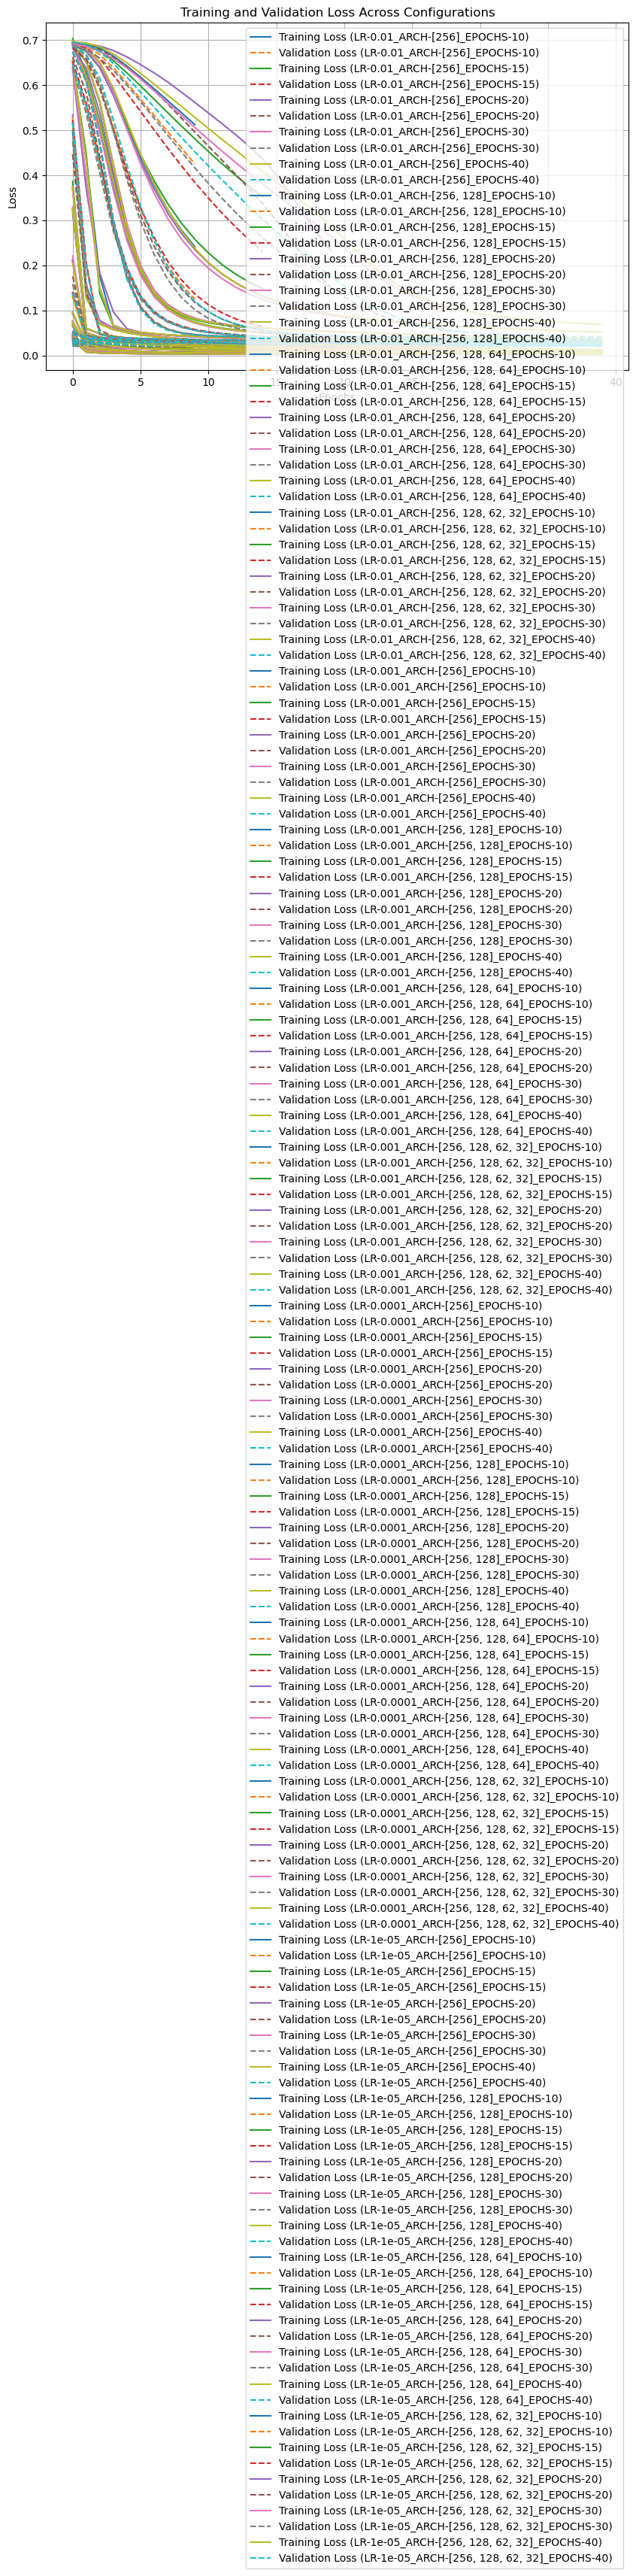


S-min @ F-max and F-max Metrics:
LR-0.01_ARCH-[256]_EPOCHS-10 -> F-max: 0.7986, S-min @ F-max: 4.7429
LR-0.01_ARCH-[256]_EPOCHS-15 -> F-max: 0.8113, S-min @ F-max: 4.4529
LR-0.01_ARCH-[256]_EPOCHS-20 -> F-max: 0.8102, S-min @ F-max: 4.5007
LR-0.01_ARCH-[256]_EPOCHS-30 -> F-max: 0.8095, S-min @ F-max: 4.4369
LR-0.01_ARCH-[256]_EPOCHS-40 -> F-max: 0.7999, S-min @ F-max: 4.6262
LR-0.01_ARCH-[256, 128]_EPOCHS-10 -> F-max: 0.7875, S-min @ F-max: 4.9993
LR-0.01_ARCH-[256, 128]_EPOCHS-15 -> F-max: 0.7922, S-min @ F-max: 4.9727
LR-0.01_ARCH-[256, 128]_EPOCHS-20 -> F-max: 0.8072, S-min @ F-max: 4.4396
LR-0.01_ARCH-[256, 128]_EPOCHS-30 -> F-max: 0.7989, S-min @ F-max: 4.8891
LR-0.01_ARCH-[256, 128]_EPOCHS-40 -> F-max: 0.8075, S-min @ F-max: 4.5776
LR-0.01_ARCH-[256, 128, 64]_EPOCHS-10 -> F-max: 0.7656, S-min @ F-max: 5.5918
LR-0.01_ARCH-[256, 128, 64]_EPOCHS-15 -> F-max: 0.7509, S-min @ F-max: 6.2056
LR-0.01_ARCH-[256, 128, 64]_EPOCHS-20 -> F-max: 0.7822, S-min @ F-max: 5.1950
LR-0.01_ARCH-[256

In [10]:
training_losses = {}
validation_losses = {}
smin_fmax_metrics = {}  
threshold_range = np.arange(0.1, 1.0, 0.1)  # Example range: [0.01, 0.99]

for lr in learning_rates:
    for arch in architectures:
        for num_epochs in epoch_counts:
            print(f"\nTraining with LR: {lr}, Arch: {arch}, Epochs: {num_epochs}")

            model = FFNN(
                input_dim=data_train_embeddings.shape[1], 
                hidden_dims=arch, 
                output_dim=data_train_labels.shape[1]
            )
            
            model_save_path = f"models/model_lr{lr}_arch{arch}_epochs{num_epochs}.pt"
            optimizer = optim.Adam(model.parameters(), lr=lr)
            criterion = nn.BCEWithLogitsLoss()
            train_losses, val_losses = train_model(
                model, data_train_loader, data_val_loader, 
                criterion, optimizer, num_epochs, device, model_save_path
            )
            config_key = f"LR-{lr}_ARCH-{arch}_EPOCHS-{num_epochs}"
            training_losses[config_key] = train_losses
            validation_losses[config_key] = val_losses
            all_preds = []
            all_targets = []
            with torch.no_grad():
                for x_batch, y_batch in data_val_loader:
                    x_batch = x_batch.to(device)
                    outputs = model(x_batch)
                    preds = torch.sigmoid(outputs).cpu().numpy()  
                    all_preds.append(preds)
                    all_targets.append(y_batch.cpu().numpy())

            y_pred_probs = np.vstack(all_preds)
            y_true = np.vstack(all_targets)

            smin, fmax, best_threshold_s, best_threshold_f, s_at_fmax, results_df = threshold_performance_metrics(
                ic_dict, y_true, y_pred_probs, threshold_range=threshold_range, mlb=data_mlb
            )
            smin_fmax_metrics[config_key] = {
                "F-max": fmax,
                "S-min @ F-max": s_at_fmax,
                "Best Threshold (F-max)": best_threshold_f,
                "Best Threshold (S-min)": best_threshold_s
            }
            results_file = f"metrics_lr{lr}_arch{arch}_epochs{num_epochs}.csv"
            results_df.to_csv(results_file, index=False)
            print(f"Saved metrics to: {results_file}")

            print(f"Completed training and evaluation for config: LR={lr}, ARCH={arch}, EPOCHS={num_epochs}")

plt.figure(figsize=(10, 6))
for key in training_losses:
    plt.plot(training_losses[key], label=f'Training Loss ({key})')
    plt.plot(validation_losses[key], label=f'Validation Loss ({key})', linestyle='--')

plt.title('Training and Validation Loss Across Configurations')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

print("\nS-min @ F-max and F-max Metrics:")
for config, metrics in smin_fmax_metrics.items():
    print(f"{config} -> F-max: {metrics['F-max']:.4f}, S-min @ F-max: {metrics['S-min @ F-max']:.4f}")

print("Process finished. Loss plot and metric evaluations completed.")

In [17]:
metrics_df = pd.DataFrame.from_dict(smin_fmax_metrics, orient='index').reset_index()
metrics_df.rename(columns={"index": "Configuration"}, inplace=True)


metrics_df

,Configuration,F-max,S-min @ F-max,Best Threshold (F-max),Best Threshold (S-min)
0,LR-0.01_ARCH-[256]_EPOCHS-10,0.798596,4.742864,0.1,0.2
1,LR-0.01_ARCH-[256]_EPOCHS-15,0.811299,4.452920,0.1,0.1
2,LR-0.01_ARCH-[256]_EPOCHS-20,0.810240,4.500718,0.1,0.2
3,LR-0.01_ARCH-[256]_EPOCHS-30,0.809473,4.436881,0.2,0.2
4,LR-0.01_ARCH-[256]_EPOCHS-40,0.799910,4.626220,0.1,0.1
...,...,...,...,...,...
75,"LR-1e-05_ARCH-[256, 128, 62, 32]_EPOCHS-10",0.120551,27.431672,0.8,0.9
76,"LR-1e-05_ARCH-[256, 128, 62, 32]_EPOCHS-15",0.226460,19.727302,0.8,0.9
77,"LR-1e-05_ARCH-[256, 128, 62, 32]_EPOCHS-20",0.276228,20.380556,0.7,0.9
78,"LR-1e-05_ARCH-[256, 128, 62, 32]_EPOCHS-30",0.392052,12.353848,0.5,0.5


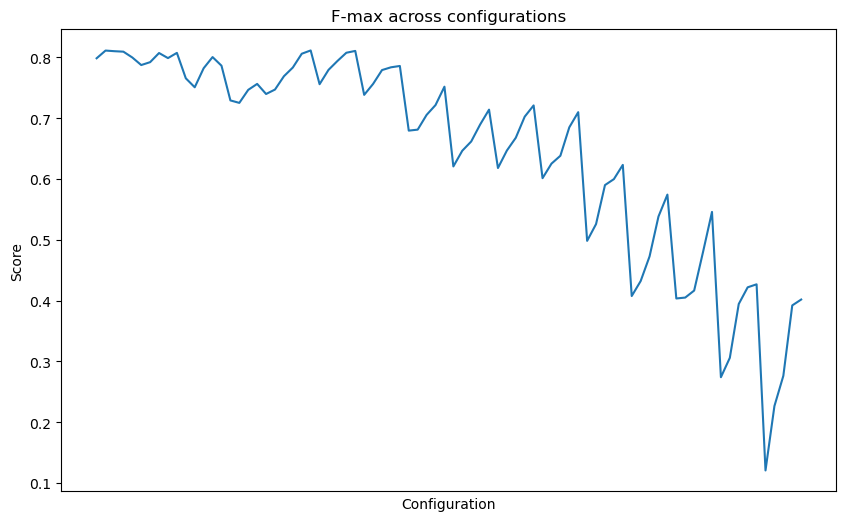

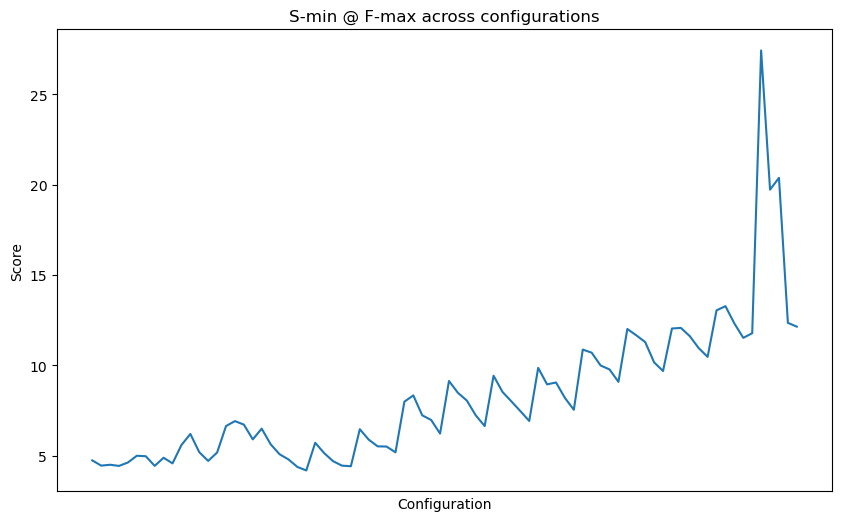

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(metrics_df["Configuration"], metrics_df["F-max"], label="F-max")
plt.title("F-max across configurations")
plt.xlabel("Configuration")
plt.xticks([])
plt.ylabel("Score")
plt.show() 

plt.figure(figsize=(10, 6))
plt.plot(metrics_df["Configuration"], metrics_df["S-min @ F-max"], label="S-min @ F-max")
plt.title("S-min @ F-max across configurations")
plt.xlabel("Configuration")
plt.xticks([])
plt.ylabel("Score")
plt.show() 


In [19]:
def find_best_config(metrics_df):
    sorted_df = metrics_df.sort_values(by=["F-max", "S-min @ F-max"], ascending=[False, True])
    return sorted_df.iloc[0]

best_config = find_best_config(metrics_df)
best_config

Configuration             LR-0.001_ARCH-[256]_EPOCHS-40
F-max                                          0.811486
S-min @ F-max                                  4.186026
Best Threshold (F-max)                              0.2
Best Threshold (S-min)                              0.2
Name: 24, dtype: object

In [20]:
def find_best_config_with_overfitting(
    metrics_df, training_losses, validation_losses
):
    overfitting_scores = {}
    for config_key in training_losses:
        final_train_loss = training_losses[config_key][-1]  # Last epoch's training loss
        final_val_loss = validation_losses[config_key][-1]  # Last epoch's validation loss
        overfitting_scores[config_key] = final_val_loss - final_train_loss

    metrics_df["Overfitting_Score"] = metrics_df["Configuration"].map(overfitting_scores)
    sorted_df = metrics_df.sort_values(
        by=["F-max", "S-min @ F-max", "Overfitting_Score"], 
        ascending=[False, True, True]
    )
    return sorted_df.iloc[0]

best_config = find_best_config_with_overfitting(metrics_df, training_losses, validation_losses)
print(best_config)


Configuration             LR-0.001_ARCH-[256]_EPOCHS-40
F-max                                          0.811486
S-min @ F-max                                  4.186026
Best Threshold (F-max)                              0.2
Best Threshold (S-min)                              0.2
Overfitting_Score                              0.017788
Name: 24, dtype: object


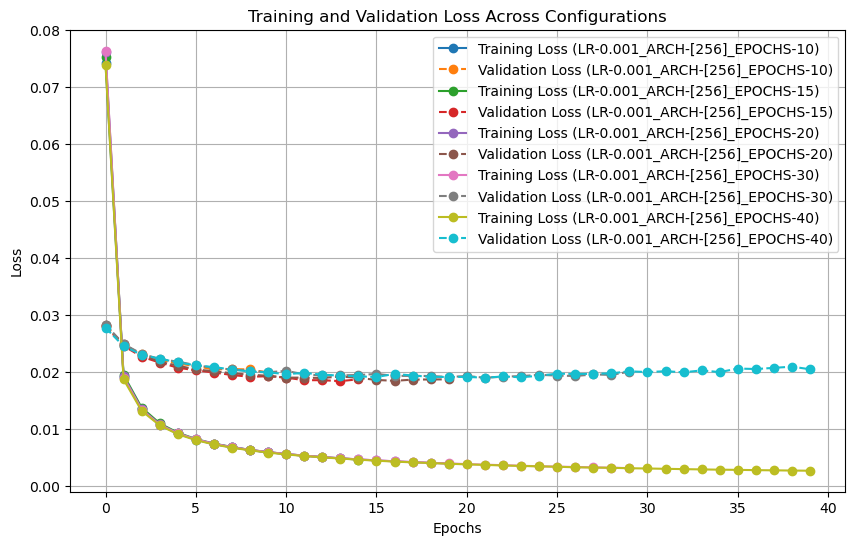

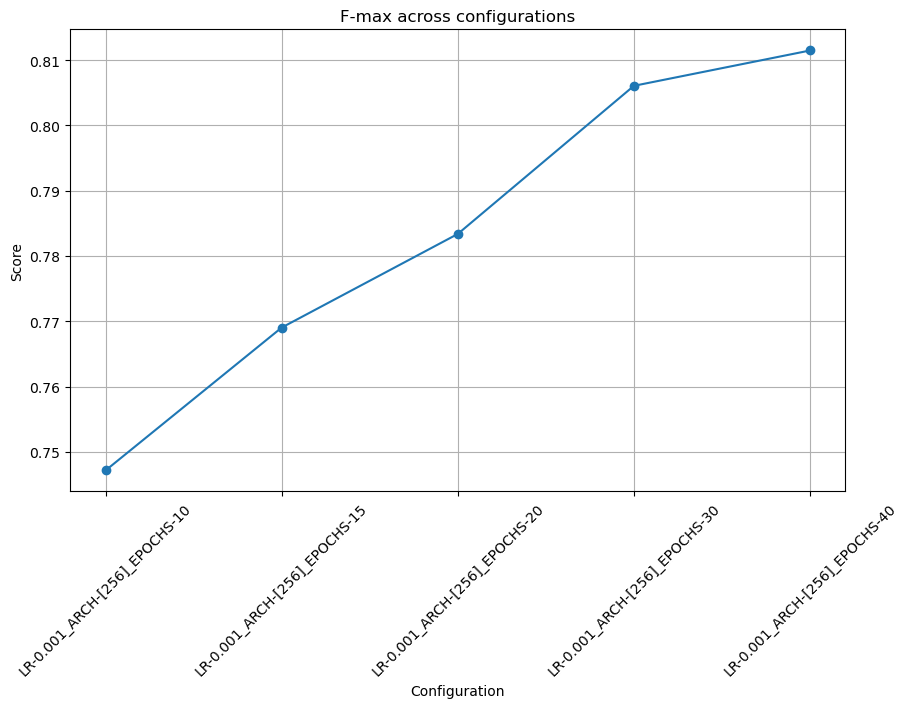

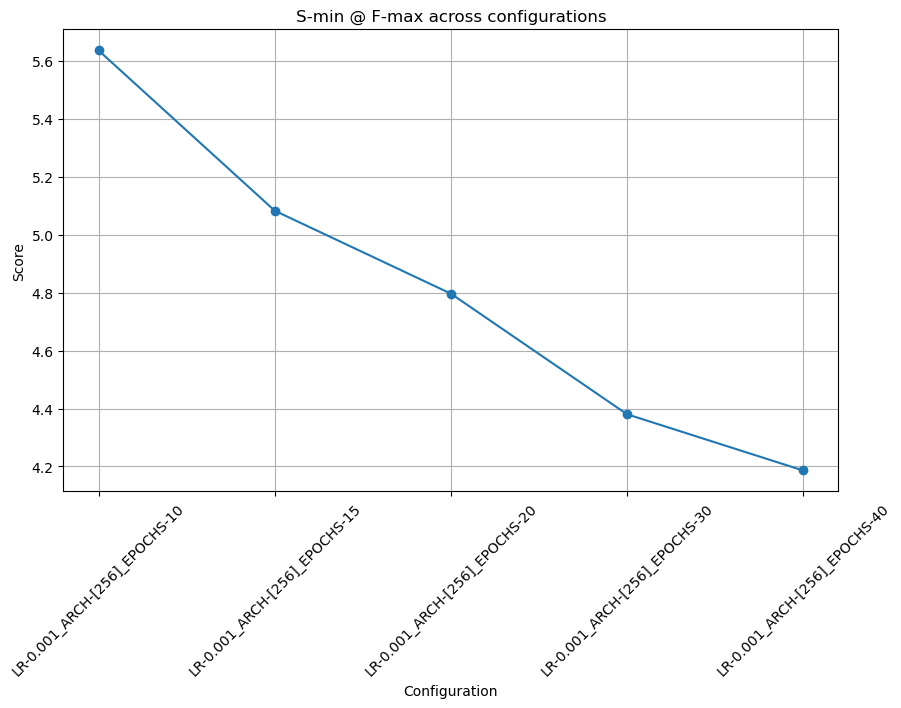

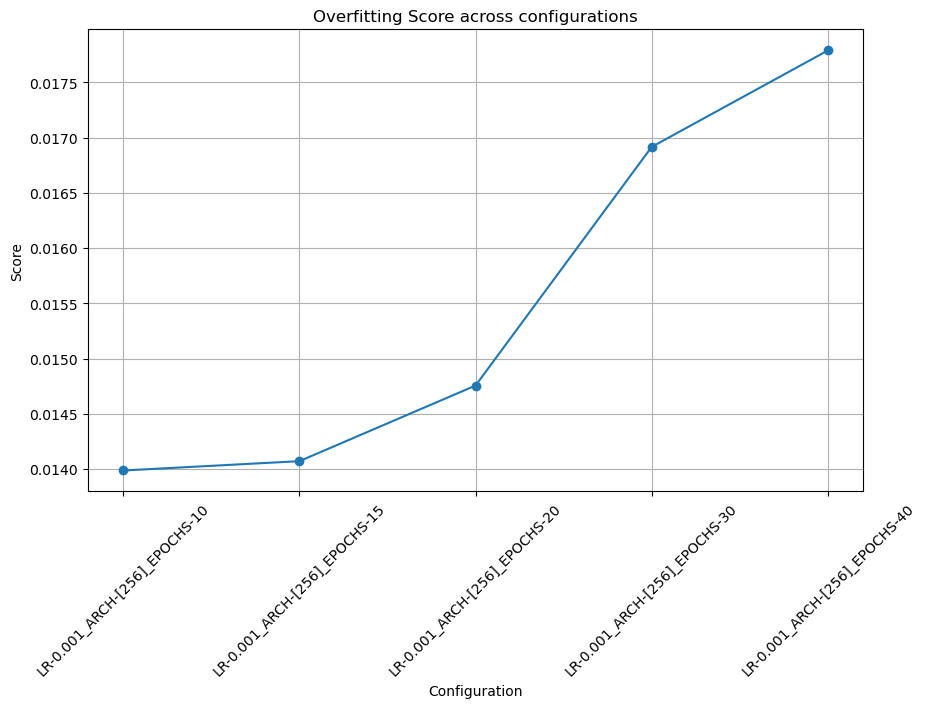

In [25]:
configs = [key for key in training_losses.keys() if "LR-0.001_ARCH-[256]" in key]
plt.figure(figsize=(10, 6))
for key in configs:
    plt.plot(training_losses[key], marker='o', label=f'Training Loss ({key})')
    plt.plot(validation_losses[key], marker='o', linestyle='--', label=f'Validation Loss ({key})')

plt.title('Training and Validation Loss Across Configurations')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="upper right")
plt.grid(True)
plt.show()
metrics_df_subset = metrics_df[metrics_df["Configuration"].isin(configs)]

plt.figure(figsize=(10, 6))
plt.plot(metrics_df_subset["Configuration"], metrics_df_subset["F-max"], marker='o', label="F-max")
plt.title("F-max across configurations")
plt.xlabel("Configuration")
plt.xticks(rotation=45)
plt.ylabel("Score")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(metrics_df_subset["Configuration"], metrics_df_subset["S-min @ F-max"], marker='o', label="S-min @ F-max")
plt.title("S-min @ F-max across configurations")
plt.xlabel("Configuration")
plt.xticks(rotation=45)
plt.ylabel("Score")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(metrics_df_subset["Configuration"], metrics_df_subset["Overfitting_Score"], marker='o', label="Overfitting Score")
plt.title("Overfitting Score across configurations")
plt.xlabel("Configuration")
plt.xticks(rotation=45)
plt.ylabel("Score")
plt.grid(True)
plt.show()


In [22]:
metrics_df.to_csv(r'MFO_metrics_df.csv', index=False)

LR-0.001_ARCH-[256, 128]_EPOCHS-30 is chosen. 

In [32]:
CHOSEN_CONFIG = 'LR-0.001_ARCH-[256]_EPOCHS-20' # helena: same but epochs 20
CHOSEN_CONFIG_LR = 0.001
CHOSEN_CONFIG_ARCH = [256]
CHOSEN_CONFIG_EPOCHS = 20


# Is there an advantage of using another Loss scheme for this architecture? 

In [33]:
from goatools.obo_parser import GODag
obodag = GODag("../go-basic.obo")

def get_level(go_term, ontology):

    try :
        return obodag[go_term].level
    except KeyError:
        return 0

data_train_GO_flat = [item for sublist in data_train_GO_list for item in sublist]
data_train_GO_list_unique = list(set(data_train_GO_flat))
data_train_GO_levels = [get_level(go_term, 'function') for go_term in data_train_GO_list_unique]

def compute_depth_weight(term_depths):
    class_weights = np.array([1 + depth/2 for depth in term_depths]) 
    return class_weights

data_train_GO_weights_depth = compute_depth_weight(data_train_GO_levels)

data_train_GO_weights_depth.shape

../go-basic.obo: fmt(1.2) rel(2025-10-10) 42,666 Terms


(1098,)

In [34]:
def compute_inverse_frequency_weight(labels):
    class_counts = np.sum(labels, axis=0)
    total_samples = labels.shape[0]
    num_classes = labels.shape[1]
    class_weights = total_samples / (num_classes * class_counts)
    return class_weights

if len(data_train_labels.shape) > 1 and data_train_labels.shape[1] > 1:  
    class_weights = compute_inverse_frequency_weight(data_train_labels)
    data_train_GO_weights_inv_freq_ = torch.tensor(class_weights, dtype=torch.float).to(device)

data_train_GO_weights_inv_freq_.shape

torch.Size([1098])

In [35]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=0.25, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = nn.BCEWithLogitsLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss

        if self.reduction == 'mean':
            return F_loss.mean()
        elif self.reduction == 'sum':
            return F_loss.sum()
        else:
            return F_loss


class JaccardLoss(nn.Module):
    def __init__(self, smooth=1):
        super(JaccardLoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        inputs = torch.sigmoid(inputs)
        intersection = (inputs * targets).sum(dim=1)
        total = (inputs + targets).sum(dim=1)
        union = total - intersection
        Jaccard = (intersection + self.smooth) / (union + self.smooth)
        return 1 - Jaccard.mean()


class HingeLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(HingeLoss, self).__init__()
        self.margin = margin

    def forward(self, inputs, targets):
        targets = 2 * targets - 1  # Convert {0,1} to {-1,1}
        hinge_loss = torch.mean(torch.clamp(self.margin - targets * inputs, min=0))
        return hinge_loss


class AsymmetricLoss(nn.Module):
    def __init__(self, gamma_neg=4, gamma_pos=1, clip=0.05, eps=1e-8):
        super(AsymmetricLoss, self).__init__()
        self.gamma_neg = gamma_neg
        self.gamma_pos = gamma_pos
        self.clip = clip
        self.eps = eps

    def forward(self, inputs, targets):
        inputs = torch.sigmoid(inputs)
        inputs = inputs.clamp(self.clip, 1.0 - self.clip)

        loss_pos = -targets * torch.log(inputs + self.eps) * (1 - inputs) ** self.gamma_pos
        loss_neg = -(1 - targets) * torch.log(1 - inputs + self.eps) * inputs ** self.gamma_neg
        loss = loss_pos + loss_neg

        return loss.mean()





Training with BCEWithLogitsLoss_balanced, LR: 0.001, Arch: [256], Epochs: 20
Starting training...


Epoch progress: 100%|██████████| 20/20 [00:16<00:00,  1.24it/s]


Training completed.


Calculating Smin & Fmax: 100%|██████████| 99/99 [00:26<00:00,  3.70it/s]


F-max @ Best Threshold (0.18000000000000002): 0.7874882526549154
S-min @ Best Threshold (0.19): 4.719648282203933
S-min @ F-max Threshold (0.18000000000000002): 4.721436331579985
Saved metrics to: metrics_BCEWithLogitsLoss_balanced_lr0.001_arch[256]_epochs20.csv
Completed BCEWithLogitsLoss_balanced | Validation Loss: 0.0190, Fmax: 0.7875, Smin: 4.7196

Training with BCEWithLogitsLoss_depth, LR: 0.001, Arch: [256], Epochs: 20
Starting training...


Epoch progress: 100%|██████████| 20/20 [00:15<00:00,  1.27it/s]


Training completed.


Calculating Smin & Fmax: 100%|██████████| 99/99 [00:26<00:00,  3.73it/s]


F-max @ Best Threshold (0.19): 0.7830519102673307
S-min @ Best Threshold (0.17): 4.90097340601488
S-min @ F-max Threshold (0.19): 4.91261517043968
Saved metrics to: metrics_BCEWithLogitsLoss_depth_lr0.001_arch[256]_epochs20.csv
Completed BCEWithLogitsLoss_depth | Validation Loss: 0.0640, Fmax: 0.7831, Smin: 4.9010

Training with BCEWithLogitsLoss_inv_freq, LR: 0.001, Arch: [256], Epochs: 20
Starting training...


Epoch progress: 100%|██████████| 20/20 [00:16<00:00,  1.25it/s]


Training completed.


Calculating Smin & Fmax: 100%|██████████| 99/99 [00:27<00:00,  3.65it/s]


F-max @ Best Threshold (0.28): 0.6805449806720479
S-min @ Best Threshold (0.26): 6.810426571855543
S-min @ F-max Threshold (0.28): 6.82803946275065
Saved metrics to: metrics_BCEWithLogitsLoss_inv_freq_lr0.001_arch[256]_epochs20.csv
Completed BCEWithLogitsLoss_inv_freq | Validation Loss: 0.0032, Fmax: 0.6805, Smin: 6.8104

Training with FocalLoss, LR: 0.001, Arch: [256], Epochs: 20
Starting training...


Epoch progress: 100%|██████████| 20/20 [00:17<00:00,  1.13it/s]


Training completed.


Calculating Smin & Fmax: 100%|██████████| 99/99 [00:29<00:00,  3.32it/s]


F-max @ Best Threshold (0.37): 0.7951399037499403
S-min @ Best Threshold (0.38): 4.58895030283124
S-min @ F-max Threshold (0.37): 4.594592362412494
Saved metrics to: metrics_FocalLoss_lr0.001_arch[256]_epochs20.csv
Completed FocalLoss | Validation Loss: 0.0014, Fmax: 0.7951, Smin: 4.5890

Training with JaccardLoss, LR: 0.001, Arch: [256], Epochs: 20
Starting training...


Epoch progress: 100%|██████████| 20/20 [00:16<00:00,  1.23it/s]


Training completed.


Calculating Smin & Fmax: 100%|██████████| 99/99 [00:26<00:00,  3.78it/s]


F-max @ Best Threshold (0.060000000000000005): 0.7294712917692256
S-min @ Best Threshold (0.01): 7.695103756008589
S-min @ F-max Threshold (0.060000000000000005): 7.8263508505673425
Saved metrics to: metrics_JaccardLoss_lr0.001_arch[256]_epochs20.csv
Completed JaccardLoss | Validation Loss: 0.3955, Fmax: 0.7295, Smin: 7.6951

Training with HingeLoss, LR: 0.001, Arch: [256], Epochs: 20
Starting training...


Epoch progress: 100%|██████████| 20/20 [00:15<00:00,  1.25it/s]


Training completed.


Calculating Smin & Fmax: 100%|██████████| 99/99 [00:30<00:00,  3.26it/s]


F-max @ Best Threshold (0.29000000000000004): 0.7943321654305096
S-min @ Best Threshold (0.3): 4.642028801963767
S-min @ F-max Threshold (0.29000000000000004): 4.6434423969263365
Saved metrics to: metrics_HingeLoss_lr0.001_arch[256]_epochs20.csv
Completed HingeLoss | Validation Loss: 0.0137, Fmax: 0.7943, Smin: 4.6420

Training with AsymmetricLoss, LR: 0.001, Arch: [256], Epochs: 20
Starting training...


Epoch progress: 100%|██████████| 20/20 [00:18<00:00,  1.09it/s]


Training completed.


Calculating Smin & Fmax: 100%|██████████| 99/99 [00:32<00:00,  3.06it/s]

F-max @ Best Threshold (0.47000000000000003): 0.8070066457965026
S-min @ Best Threshold (0.49): 4.4620112599078885
S-min @ F-max Threshold (0.47000000000000003): 4.475050492391281
Saved metrics to: metrics_AsymmetricLoss_lr0.001_arch[256]_epochs20.csv
Completed AsymmetricLoss | Validation Loss: 0.0049, Fmax: 0.8070, Smin: 4.4620


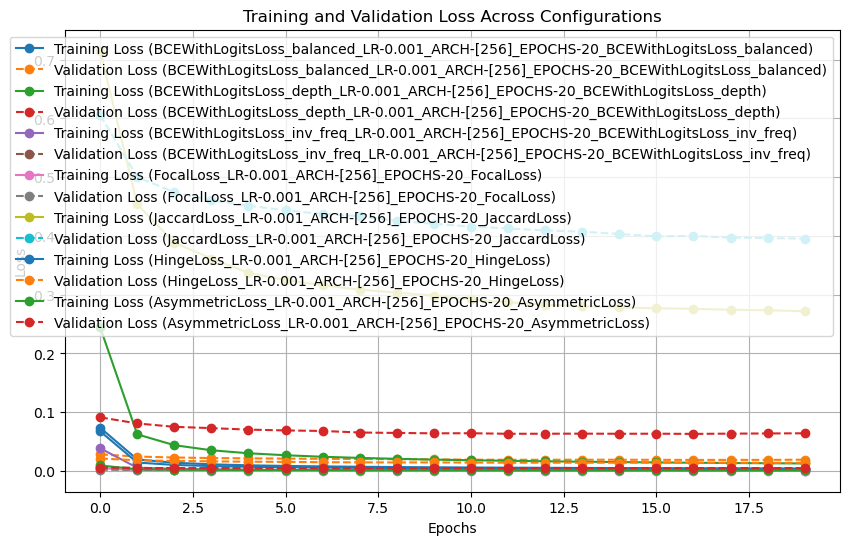


S-min @ F-max and F-max Metrics:
BCEWithLogitsLoss_balanced_LR-0.001_ARCH-[256]_EPOCHS-20_BCEWithLogitsLoss_balanced -> F-max: 0.7875, S-min @ F-max: 4.7214
BCEWithLogitsLoss_depth_LR-0.001_ARCH-[256]_EPOCHS-20_BCEWithLogitsLoss_depth -> F-max: 0.7831, S-min @ F-max: 4.9126
BCEWithLogitsLoss_inv_freq_LR-0.001_ARCH-[256]_EPOCHS-20_BCEWithLogitsLoss_inv_freq -> F-max: 0.6805, S-min @ F-max: 6.8280
FocalLoss_LR-0.001_ARCH-[256]_EPOCHS-20_FocalLoss -> F-max: 0.7951, S-min @ F-max: 4.5946
JaccardLoss_LR-0.001_ARCH-[256]_EPOCHS-20_JaccardLoss -> F-max: 0.7295, S-min @ F-max: 7.8264
HingeLoss_LR-0.001_ARCH-[256]_EPOCHS-20_HingeLoss -> F-max: 0.7943, S-min @ F-max: 4.6434
AsymmetricLoss_LR-0.001_ARCH-[256]_EPOCHS-20_AsymmetricLoss -> F-max: 0.8070, S-min @ F-max: 4.4751
Process finished. Loss plot and metric evaluations completed.


In [37]:
training_losses = {}
validation_losses = {}
smin_fmax_metrics = {}

threshold_range = np.arange(0.01, 1.0, 0.01)

architectures = [CHOSEN_CONFIG_ARCH]  
learning_rates = [CHOSEN_CONFIG_LR]
epoch_counts = [CHOSEN_CONFIG_EPOCHS]

loss_functions = {
    'BCEWithLogitsLoss_balanced': nn.BCEWithLogitsLoss(),
    'BCEWithLogitsLoss_depth': nn.BCEWithLogitsLoss(
        weight=torch.tensor(data_train_GO_weights_depth, dtype=torch.float).to(device)
    ),
    'BCEWithLogitsLoss_inv_freq': nn.BCEWithLogitsLoss(weight=data_train_GO_weights_inv_freq_),
    'FocalLoss': FocalLoss(),
    'JaccardLoss': JaccardLoss(),
    'HingeLoss': HingeLoss(),
    'AsymmetricLoss': AsymmetricLoss()
}

for loss_name, loss_fn in loss_functions.items():
    for lr in learning_rates:
        for arch in architectures:
            for num_epochs in epoch_counts:
                print(f"\nTraining with {loss_name}, LR: {lr}, Arch: {arch}, Epochs: {num_epochs}")

                model = FFNN(
                    input_dim=data_train_embeddings.shape[1], 
                    hidden_dims=arch, 
                    output_dim=data_train_labels.shape[1]
                )
                
                model_save_path = f"models/{loss_name}_lr{lr}_arch{arch}_epochs{num_epochs}.pt"

                optimizer = optim.Adam(model.parameters(), lr=lr)

                train_losses, val_losses = train_model(
                    model, data_train_loader, data_val_loader, 
                    loss_fn, optimizer, num_epochs, device, model_save_path
                )

                config_key = f"{loss_name}_LR-{lr}_ARCH-{arch}_EPOCHS-{num_epochs}_{loss_name}"
                training_losses[config_key] = train_losses
                validation_losses[config_key] = val_losses

                all_preds = []
                all_targets = []
                with torch.no_grad():
                    for x_batch, y_batch in data_val_loader:
                        x_batch = x_batch.to(device)
                        outputs = model(x_batch)
                        preds = torch.sigmoid(outputs).cpu().numpy()  
                        all_preds.append(preds)
                        all_targets.append(y_batch.cpu().numpy())

                y_pred_probs = np.vstack(all_preds)
                y_true = np.vstack(all_targets)

                smin, fmax, best_threshold_s, best_threshold_f, s_at_fmax, results_df = threshold_performance_metrics(
                    ic_dict=ic_dict,
                    y_true=y_true,
                    y_pred_probs=y_pred_probs,
                    threshold_range=threshold_range,
                    n_jobs=1,
                    mlb=data_mlb
                )

                smin_fmax_metrics[config_key] = {
                    "F-max": fmax,
                    "S-min @ F-max": s_at_fmax,
                    "Best Threshold (F-max)": best_threshold_f,
                    "Best Threshold (S-min)": best_threshold_s
                }

                results_file = f"metrics_{loss_name}_lr{lr}_arch{arch}_epochs{num_epochs}.csv"
                results_df.to_csv(results_file, index=False)
                print(f"Saved metrics to: {results_file}")

                print(f"Completed {loss_name} | Validation Loss: {val_losses[-1]:.4f}, "
                      f"Fmax: {fmax:.4f}, Smin: {smin:.4f}")

plt.figure(figsize=(10, 6))
for key in training_losses:
    plt.plot(training_losses[key], marker='o', label=f'Training Loss ({key})')
    plt.plot(validation_losses[key], marker='o', linestyle='--', label=f'Validation Loss ({key})')

plt.title('Training and Validation Loss Across Configurations')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

# Print F-max and S-min @ F-max metrics for all configurations
print("\nS-min @ F-max and F-max Metrics:")
for config, metrics in smin_fmax_metrics.items():
    print(f"{config} -> F-max: {metrics['F-max']:.4f}, S-min @ F-max: {metrics['S-min @ F-max']:.4f}")

print("Process finished. Loss plot and metric evaluations completed.")


In [38]:
smin_fmax_metrics

{'BCEWithLogitsLoss_balanced_LR-0.001_ARCH-[256]_EPOCHS-20_BCEWithLogitsLoss_balanced': {'F-max': 0.7874882526549154,
  'S-min @ F-max': 4.721436331579985,
  'Best Threshold (F-max)': np.float64(0.18000000000000002),
  'Best Threshold (S-min)': np.float64(0.19)},
 'BCEWithLogitsLoss_depth_LR-0.001_ARCH-[256]_EPOCHS-20_BCEWithLogitsLoss_depth': {'F-max': 0.7830519102673307,
  'S-min @ F-max': 4.91261517043968,
  'Best Threshold (F-max)': np.float64(0.19),
  'Best Threshold (S-min)': np.float64(0.17)},
 'BCEWithLogitsLoss_inv_freq_LR-0.001_ARCH-[256]_EPOCHS-20_BCEWithLogitsLoss_inv_freq': {'F-max': 0.6805449806720479,
  'S-min @ F-max': 6.82803946275065,
  'Best Threshold (F-max)': np.float64(0.28),
  'Best Threshold (S-min)': np.float64(0.26)},
 'FocalLoss_LR-0.001_ARCH-[256]_EPOCHS-20_FocalLoss': {'F-max': 0.7951399037499403,
  'S-min @ F-max': 4.594592362412494,
  'Best Threshold (F-max)': np.float64(0.37),
  'Best Threshold (S-min)': np.float64(0.38)},
 'JaccardLoss_LR-0.001_ARCH-[25